In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
import glob
import numpy as np
from collections import Counter
from roboflow import Roboflow

In [4]:
rf = Roboflow(api_key="fUtTYMDMJUYdsKJ9g5h0")
project = rf.workspace().project("wall-crack-texture")
dataset = project.version("1").download("yolov5pytorch")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Wall-Crack-Texture-1 in yolov5pytorch:: 100%|██████████| 1807/1807 [00:00<00:00, 6383.51it/s]


In [8]:
base_dir = '/content/Wall-Crack-Texture-1'
train_image_dir = os.path.join(base_dir, 'train/images')
train_label_dir = os.path.join(base_dir, 'train/labels')
valid_image_dir = os.path.join(base_dir, 'valid/images')
valid_label_dir = os.path.join(base_dir, 'valid/labels')
test_image_dir = os.path.join(base_dir, 'test/images')
test_label_dir = os.path.join(base_dir, 'test/labels')

def count_files(image_dir, label_dir):
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) if os.path.exists(image_dir) else []
    label_files = glob.glob(os.path.join(label_dir, '*.txt')) if os.path.exists(label_dir) else []
    return len(image_files), len(label_files)

train_image_count, train_label_count = count_files(train_image_dir, train_label_dir)
valid_image_count, valid_label_count = count_files(valid_image_dir, valid_label_dir)
test_image_count, test_label_count = count_files(test_image_dir, test_label_dir)

print("Dataset Summary:")
print(f"Training - Images: {train_image_count}, Labels: {train_label_count}")
print(f"Validation - Images: {valid_image_count}, Labels: {valid_label_count}")
print(f"Testing - Images: {test_image_count}, Labels: {test_label_count}")
print(f"Total Images: {train_image_count + valid_image_count + test_image_count}")

Dataset Summary:
Training - Images: 629, Labels: 629
Validation - Images: 180, Labels: 180
Testing - Images: 89, Labels: 89
Total Images: 898


Total counts across all datasets:
Large_crack: 319
No_crack: 371
Small_crack: 425


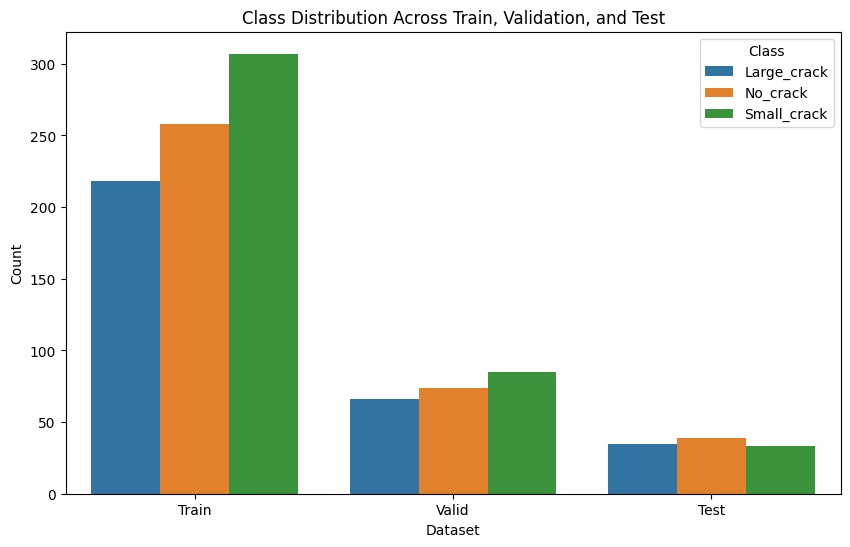

In [14]:
base_dir = '/content/Wall-Crack-Texture-1'
train_label_dir = os.path.join(base_dir, 'train/labels')
valid_label_dir = os.path.join(base_dir, 'valid/labels')
test_label_dir = os.path.join(base_dir, 'test/labels')

class_distributions = {
    'train': {'large_crack': 0, 'no_crack': 0, 'small_crack': 0},
    'valid': {'large_crack': 0, 'no_crack': 0, 'small_crack': 0},
    'test': {'large_crack': 0, 'no_crack': 0, 'small_crack': 0},
}

def count_classes(label_dir, distribution_dict):
    if not os.path.exists(label_dir):
        return
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    for label_file in label_files:
        with open(label_file, 'r') as file:
            for line in file:
                class_id = int(line.strip().split()[0])
                if class_id == 0:
                    distribution_dict['large_crack'] += 1
                elif class_id == 1:
                    distribution_dict['no_crack'] += 1
                elif class_id == 2:
                    distribution_dict['small_crack'] += 1

# Count classes for each subset
count_classes(train_label_dir, class_distributions['train'])
count_classes(valid_label_dir, class_distributions['valid'])
count_classes(test_label_dir, class_distributions['test'])

# Calculate totals
totals = {
    'large_crack': sum(d['large_crack'] for d in class_distributions.values()),
    'no_crack': sum(d['no_crack'] for d in class_distributions.values()),
    'small_crack': sum(d['small_crack'] for d in class_distributions.values())
}

# Print total counts
print("Total counts across all datasets:")
for category, total in totals.items():
    print(f"{category.capitalize()}: {total}")

# Plot combined data
combined_counts = []
categories = []
datasets = []

for dataset, counts in class_distributions.items():
    for category, count in counts.items():
        datasets.append(dataset.capitalize())
        categories.append(category.capitalize())
        combined_counts.append(count)

plt.figure(figsize=(10, 6))
sns.barplot(x=datasets, y=combined_counts, hue=categories)
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Class Distribution Across Train, Validation, and Test")
plt.legend(title="Class")
plt.show()

Sample Images from Train Dataset:


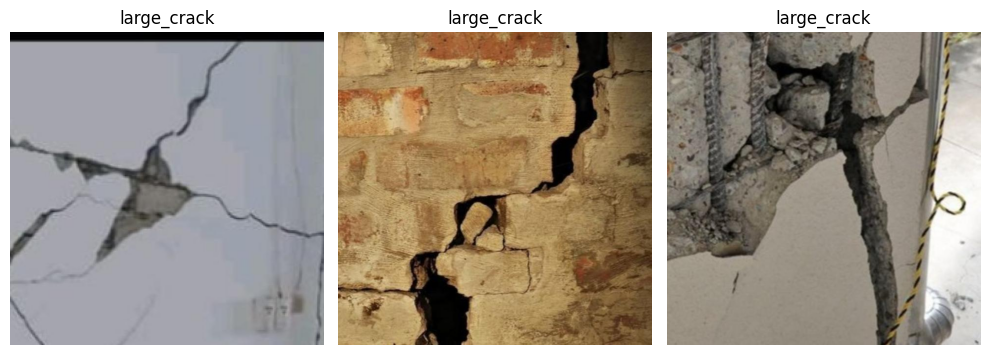

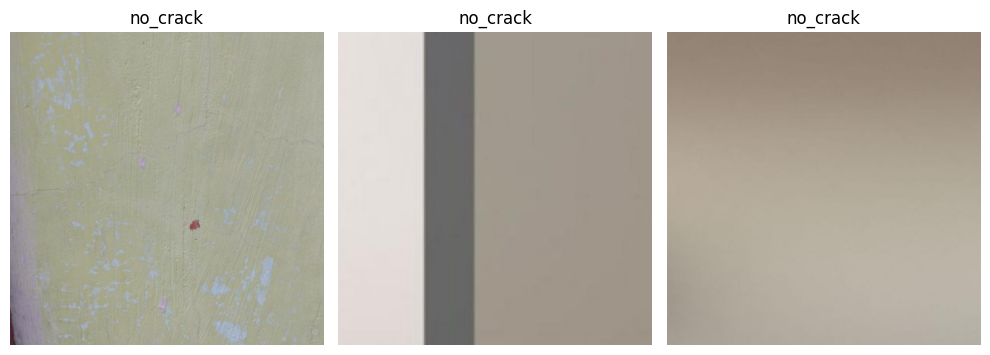

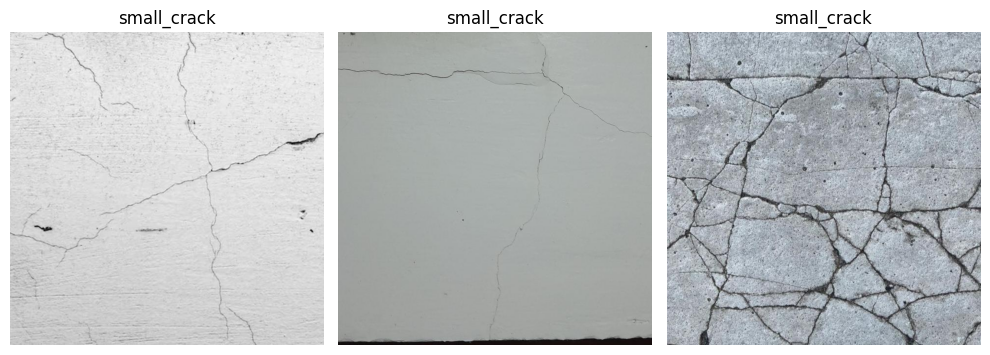

In [15]:
def plot_sample_images(label_dir, image_dir, class_id, class_name):
    sample_files = []
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as file:
            # Check if the file contains the class_id
            if any(int(line.split()[0]) == class_id for line in file):
                image_path = os.path.join(image_dir, os.path.basename(label_file).replace('.txt', '.jpg'))
                sample_files.append(image_path)
                if len(sample_files) >= 3:  # Limit to 3 samples
                    break

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(sample_files):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

base_dir = '/content/Wall-Crack-Texture-1'
train_image_dir = os.path.join(base_dir, 'train/images')
train_label_dir = os.path.join(base_dir, 'train/labels')

print("Sample Images from Train Dataset:")
plot_sample_images(train_label_dir, train_image_dir, 0, 'large_crack')
plot_sample_images(train_label_dir, train_image_dir, 1, 'no_crack')
plot_sample_images(train_label_dir, train_image_dir, 2, 'small_crack')

Aspect Ratio Distribution - Train Dataset


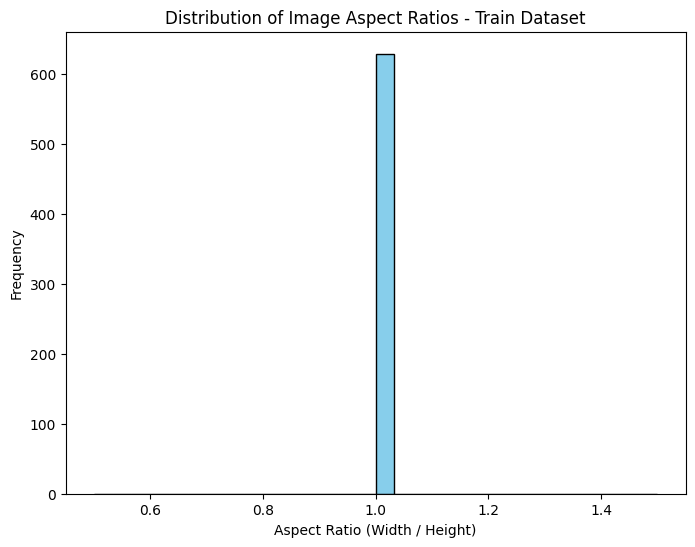

Aspect Ratio Distribution - Validation Dataset


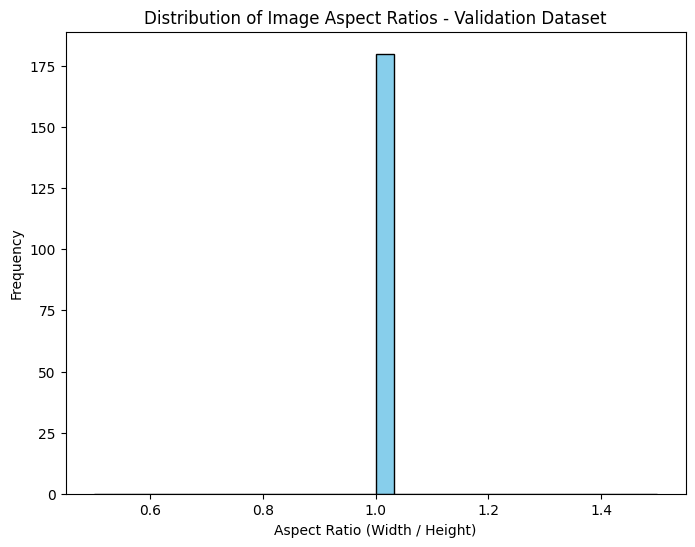

Aspect Ratio Distribution - Test Dataset


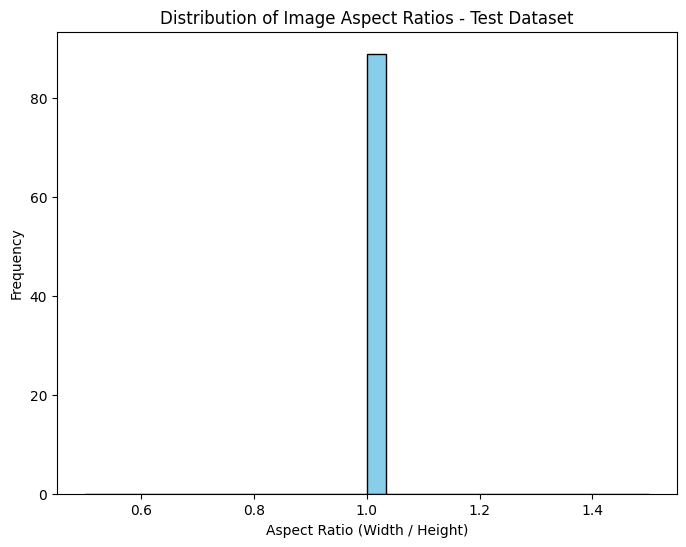

In [17]:
def plot_aspect_ratios(image_dir, subset_name):
    aspect_ratios = []
    image_files = glob.glob(os.path.join(image_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path)
        if img is not None:  # Ensure image is read correctly
            h, w, _ = img.shape
            aspect_ratios.append(w / h)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Image Aspect Ratios - {subset_name.capitalize()} Dataset")
    plt.show()

# Paths for subsets
base_dir = '/content/Wall-Crack-Texture-1'
train_image_dir = os.path.join(base_dir, 'train/images')
valid_image_dir = os.path.join(base_dir, 'valid/images')
test_image_dir = os.path.join(base_dir, 'test/images')

# Plot aspect ratio distributions for each subset
print("Aspect Ratio Distribution - Train Dataset")
plot_aspect_ratios(train_image_dir, "train")

print("Aspect Ratio Distribution - Validation Dataset")
plot_aspect_ratios(valid_image_dir, "validation")

print("Aspect Ratio Distribution - Test Dataset")
plot_aspect_ratios(test_image_dir, "test")

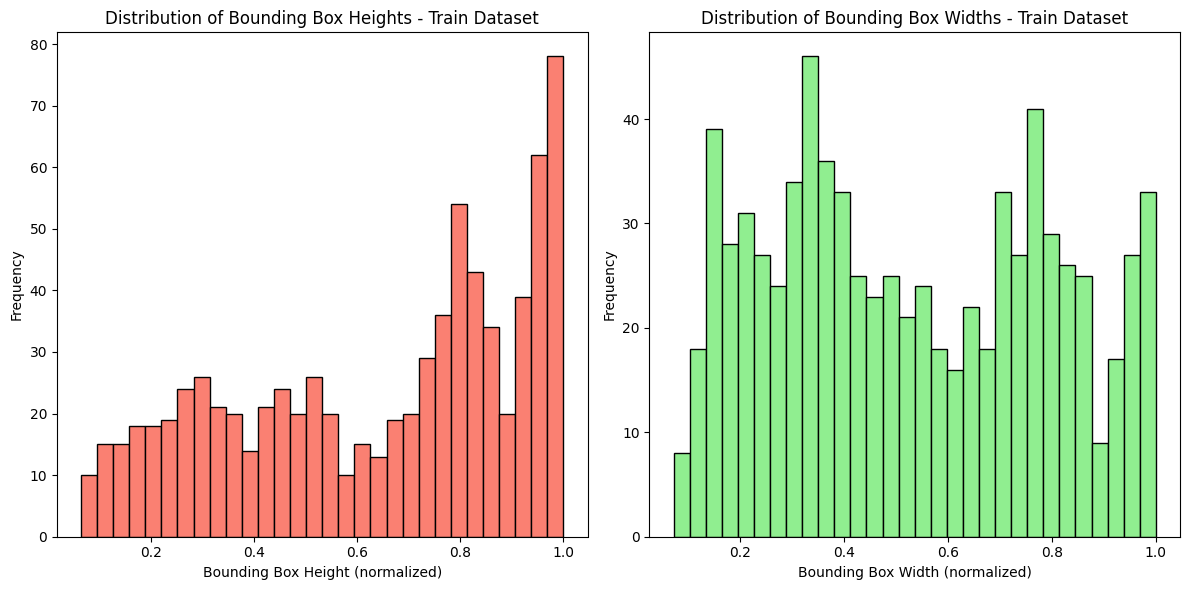

In [18]:
box_widths = []
box_heights = []

# Daftar file label di direktori train
label_files = glob.glob(os.path.join(train_label_dir, '*.txt'))

# Memproses bounding box dari file label
for label_file in label_files:
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:  # Format YOLO: class_id, x_center, y_center, box_width, box_height
                try:
                    _, _, _, box_width, box_height = map(float, parts)
                    box_widths.append(box_width)
                    box_heights.append(box_height)
                except ValueError as e:
                    print(f"Error parsing line in {label_file}: {line} -> {e}")
            else:
                print(f"Skipping invalid line in {label_file}: {line}")

# Visualisasi distribusi lebar dan tinggi bounding box
plt.figure(figsize=(12, 6))

# Histogram untuk tinggi bounding box
plt.subplot(1, 2, 1)
plt.hist(box_heights, bins=30, color='salmon', edgecolor='black')
plt.xlabel("Bounding Box Height (normalized)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Heights - Train Dataset")

# Histogram untuk lebar bounding box
plt.subplot(1, 2, 2)
plt.hist(box_widths, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("Bounding Box Width (normalized)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Widths - Train Dataset")

plt.tight_layout()
plt.show()

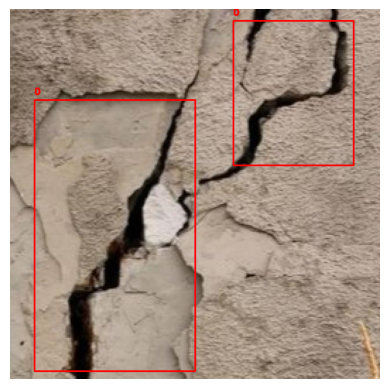

In [53]:
def visualize_bounding_boxes(image_path, label_path, class_colors=None):
    """
    Visualize bounding boxes on an image based on YOLO labels.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Assign default colors if not provided
    if class_colors is None:
        class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}  # Default: red, green, blue

    if not os.path.exists(label_path):
        print(f"Warning: Label file {label_path} not found.")
        return

    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 5:
                print(f"Warning: Skipping invalid label line in {label_path}: {line}")
                continue

            try:
                class_id = int(parts[0])
                x_center, y_center, box_width, box_height = map(float, parts[1:])
            except ValueError as e:
                print(f"Error parsing line in {label_path}: {line} -> {e}")
                continue

            # Convert normalized coordinates to absolute pixel values
            x_center *= w
            y_center *= h
            box_width *= w
            box_height *= h

            # Calculate top-left and bottom-right corners of the bounding box
            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            # Determine color for the class ID
            color = class_colors.get(class_id, (255, 255, 0))  # Default color is yellow
            img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            img = cv2.putText(img, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Paths to train images and labels
image_dir = '/content/Wall-Crack-Texture-1/train/images'
label_dir = '/content/Wall-Crack-Texture-1/train/labels'

# List image and label files
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [os.path.join(label_dir, f.replace('.jpg', '.txt')) for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Ensure dataset consistency
if len(image_files) != len(label_files):
    print("Warning: Mismatch between image and label file counts.")

# Visualize a sample image with bounding boxes
sample_index = 30  # Change this index to visualize other samples
if sample_index < len(image_files):
    sample_image_path = image_files[sample_index]
    sample_label_path = label_files[sample_index]
    visualize_bounding_boxes(sample_image_path, sample_label_path)
else:
    print(f"Error: Sample index {sample_index} is out of bounds.")

In [54]:
def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1 - w1 / 2, x2 - w2 / 2)
    yi1 = max(y1 - h1 / 2, y2 - h2 / 2)
    xi2 = min(x1 + w1 / 2, x2 + w2 / 2)
    yi2 = min(y1 + h1 / 2, y2 + h2 / 2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

overlap_counts = []

for label_file in label_files:
    with open(label_file, 'r') as file:
        boxes = [list(map(float, line.strip().split()[1:])) for line in file]
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                if iou(boxes[i], boxes[j]) > 0.5:
                    overlap_counts.append(1)

print(f"Number of overlapping bounding boxes: {sum(overlap_counts)}")

Number of overlapping bounding boxes: 0


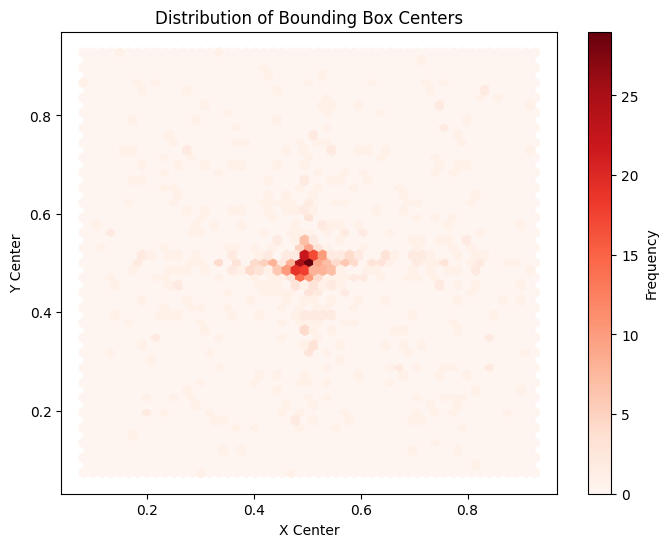

In [58]:
import matplotlib.pyplot as plt

# Menyimpan nilai x_center dan y_center
x_centers = []
y_centers = []

# Proses setiap file label
for label_file in label_files:
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()

            # Tambahkan elemen default (0) jika kurang dari lima elemen
            if len(parts) < 5:
                parts.extend(['0'] * (5 - len(parts)))  # Menambahkan '0' untuk elemen yang hilang

            # Konversi elemen menjadi float, elemen pertama diabaikan karena class_id
            try:
                _, x_center, y_center, _, _ = map(float, parts[:5])  # Pastikan hanya lima elemen yang dipakai
                x_centers.append(x_center)
                y_centers.append(y_center)
            except ValueError as e:
                print(f"Warning: Could not convert some elements to float in {label_file}: {line}")

# Visualisasi distribusi x_center dan y_center
plt.figure(figsize=(8, 6))
plt.hexbin(x_centers, y_centers, gridsize=50, cmap='Reds')
plt.colorbar(label="Frequency")
plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.title("Distribution of Bounding Box Centers")
plt.show()

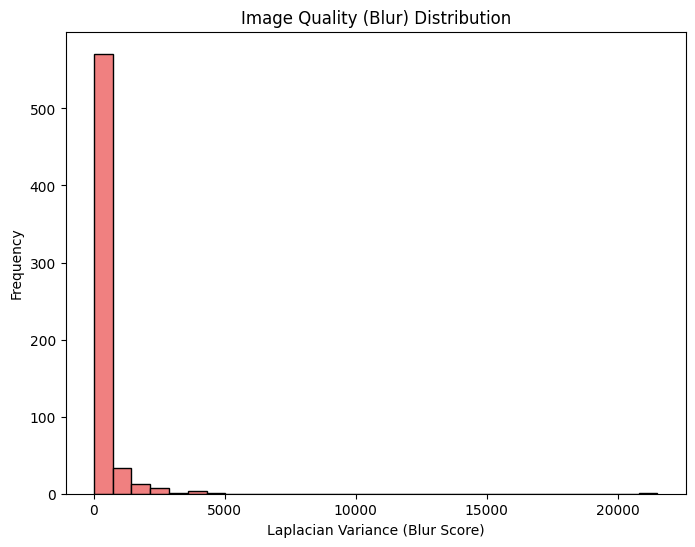

Number of blurry images (below threshold): 393


In [59]:
blur_scores = []

# Hitung skor blur untuk setiap gambar
for img_path in image_files:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
    blur_scores.append(blur_score)

# Visualisasi distribusi skor blur
plt.figure(figsize=(8, 6))
plt.hist(blur_scores, bins=30, color='lightcoral', edgecolor='black')
plt.xlabel("Laplacian Variance (Blur Score)")
plt.ylabel("Frequency")
plt.title("Image Quality (Blur) Distribution")
plt.show()

# Tentukan ambang batas untuk gambar buram
blur_threshold = 100  # Angka acuan, dapat disesuaikan
blurry_images = sum(1 for score in blur_scores if score < blur_threshold)
print(f"Number of blurry images (below threshold): {blurry_images}")